<p style="font-size:32px;text-align:center"> <b>Personalized Cancer Diagnosis</b> </p>

<h1>1. Business Problem</h1>

<h2>1.1. Description</h2>

<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/ </p>
<p> Data: Memorial Sloan Kettering Cancer Center (MSKCC)</p>

<h6> Context:</h6>
<p> Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462</p>

<h6> Problem statement : </h6>
<p> Classify the given genetic variations/mutations based on evidence from text-based clinical literature. </p>

<h2>1.2. Real-world/Business objectives and constraints.</h2>

* No low-latency requirement.
* Interpretability is important.
* Errors can be very costly.
* Probability of a data-point belonging to each class is needed.

<h1>2. Machine Learning Problem Formulation</h1>

<h2>2.1. Data</h2>

<h3>2.1.1. Data Overview</h3>

- Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment/data
- We have two data files: one conatins the information about the genetic mutations and the other contains the clinical evidence (text) that  human experts/pathologists use to classify the genetic mutations. 
- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

<h3>2.1.2. Example Data Point</h3>

<h4>training_variants</h4>
<hr>
ID,Gene,Variation,Class<br>
0,FAM58A,Truncating Mutations,1 <br>
1,CBL,W802*,2 <br>
2,CBL,Q249E,2 <br>
...

<h4> training_text</h4>
<hr>
ID,Text <br>
0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10...

<h2>2.2. Mapping the real-world problem to an ML problem</h2>

<h3>2.2.1. Type of Machine Learning Problem</h3>

<p>There are nine different classes a genetic mutation can be classified into => Multi class classification problem    
</p>

<h3>2.2.2. Performance Metric</h3>

Source: https://www.kaggle.com/c/msk-redefining-cancer-treatment#evaluation

Metric(s): 
* Multi class log-loss 
* Confusion matrix 

<h3>2.2.3. Machine Learing Objectives and Constraints</h3>

<p> Objective: Predict the probability of each data-point belonging to each of the nine classes.
</p>
<p> Constraints:
</p>
* Interpretability
* Class probabilities are needed.
* Penalize the errors in class probabilites => Metric is Log-loss.
* No Latency constraints.

<h2>2.3. Train, CV and Test Datasets</h2>

 Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

<h1>3. Exploratory Data Analysis</h1>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

/Users/hemantmehra/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h2>3.1. Reading Data</h2>

<h3>3.1.1. Reading Gene and Variation Data</h3>

In [3]:
data = pd.read_csv("training/training_variants")
print("No. of data points", data.shape[0])
print("No. of features", data.shape[1])
print("Features: ", data.columns.values)
data.head()

No. of data points 3321
No. of features 4
Features:  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<p>training/training_variants is a comma separated file containing the description of the genetic mutations used for training.</p>
Fields are 
<ul>
    <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
    <li><b>Gene : </b>the gene where this genetic mutation is located </li>
    <li><b>Variation : </b>the aminoacid change for this mutations </li>
    <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
</ul>

<h3>3.1.2. Reading Text Data</h3>

In [4]:
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print("Number of data points: ", data_text.shape[0])
print("Number of features: ", data_text.shape[1])
print("Features: ", data_text.columns.values)
data_text.head()

Number of data points:  3321
Number of features:  2
Features:  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


<h3>3.1.3. Preprocessing of text</h3>

In [5]:
stopwords = set(stopwords.words("english"))

def nlp_preprocessing(text, index, column):
    if type(text) is not int:
        string = ""
        text = re.sub('[^a-zA-Z0-9\n]', ' ', text)
        text = re.sub('\s+',' ', text)
        text = text.lower()
        for word in text.split():
            if word not in stopwords:
                string += word + " "
        data_text[column][index] = string

In [6]:
start_time = time.clock()
for index, row in data_text.iterrows():
    nlp_preprocessing(row["TEXT"], index, 'TEXT')
print('Time: %.2f sec'%(time.clock() - start_time))

Time: 225.08 sec


In [7]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


<h3>3.1.4. Test, Train and Cross Validation Split</h3>

<h4>3.1.4.1. Splitting data into train, test and cross validation (64:20:16)</h4>

In [8]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [9]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


<h4>3.1.4.2. Distribution of y_i's in Train, Test and Cross Validation datasets</h4>

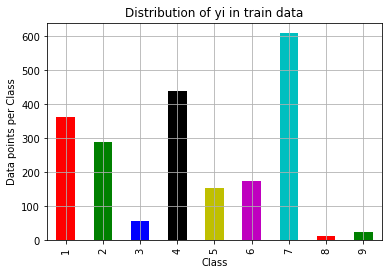

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


In [11]:
train_class_distribution = train_df['Class'].value_counts().sortlevel()
test_class_distribution = test_df['Class'].value_counts().sortlevel()
cv_class_distribution = cv_df['Class'].value_counts().sortlevel()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

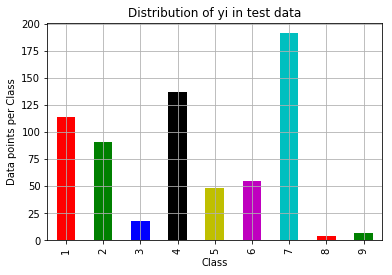

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


In [12]:
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

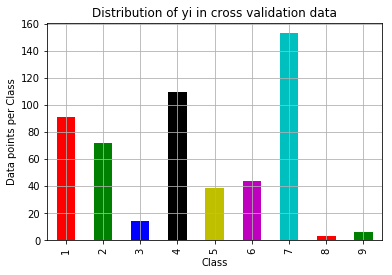

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


In [13]:
cv_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

## 3.2 Prediction using a Random Model

In [24]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A = (((C.T)/(C.sum(axis = 1))).T)
    B = (C/(C.sum(axis = 0)))
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.500933411853345
Log loss on Test Data using Random Model 2.4822913532721764
-------------------- Confusion matrix --------------------


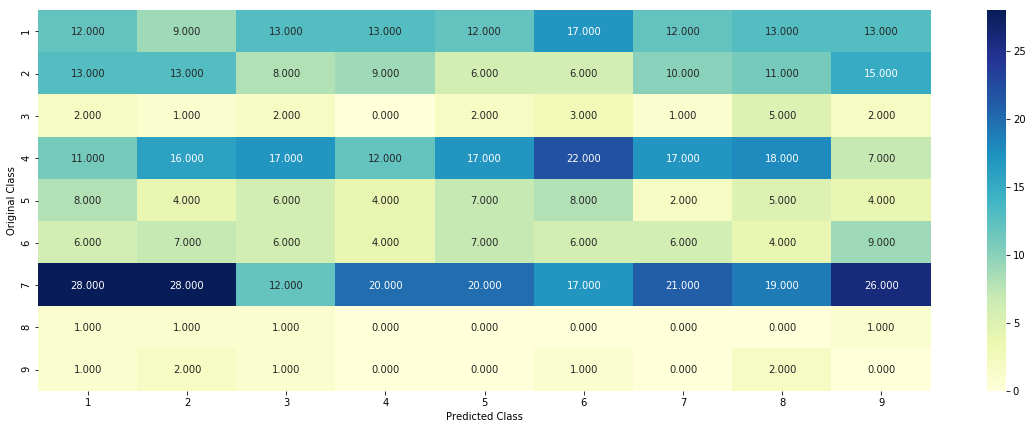

-------------------- Precision matrix (Columm Sum=1) --------------------


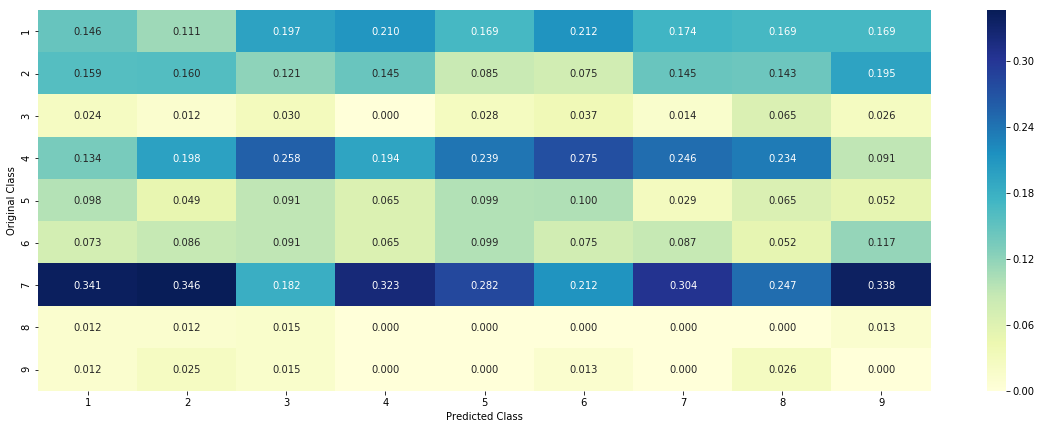

-------------------- Recall matrix (Row sum=1) --------------------


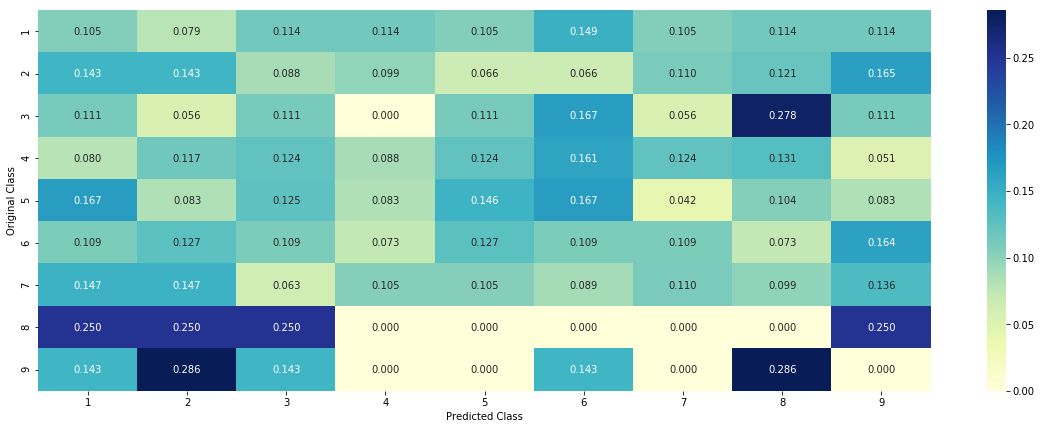

In [25]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

## 3.2 Univariate Analysis

In [45]:
# Response coding with Laplace smoothing

def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    gv_dict = dict()
    
    for item, total_count in value_count.items():
        vec = []
        for k in range(1, 10):
            # count = number of dataitem with class k and Gene/Variation item
            temp_df = train_df.loc[(train_df['Class'] == k) & (train_df[feature] == item)]
            count = temp_df.shape[0]
            vec.append((count + alpha * 10)/(total_count + alpha * 90))
        
        gv_dict[item] = vec
    return gv_dict

def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    gv_fea = []
    
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea
            

### 3.2.1 Univariate Analysis on Gene feature

<p style="font-size:18px;"> <b>Q1.</b>What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [46]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
print(unique_genes.head(10))

Number of Unique Genes : 241
BRCA1    179
TP53     114
EGFR      97
PTEN      75
BRCA2     73
BRAF      59
KIT       56
ERBB2     47
ALK       44
TSC2      37
Name: Gene, dtype: int64


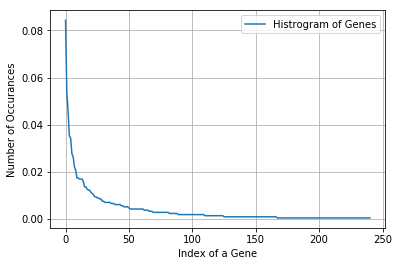

In [47]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

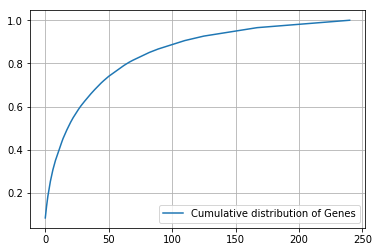

In [48]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>
<p>There are two ways we can featurize this variable</p>
1. One Hot Encoding
2. Response Coding

In [50]:
# Response Coding
alpha = 1
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [51]:
print("The shape of gene feature (Response Coding):", train_gene_feature_responseCoding.shape)

The shape of gene feature (Response Coding): (2124, 9)


In [52]:
# One Hot Encoding
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [53]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gli1',
 'gnaq',
 'gnas',
 'h3f3a',
 'hla',
 'hnf1a',
 'hras',
 'idh1',

In [54]:
print("The shape of gene feature (One Hot Encoding):", train_gene_feature_onehotCoding.shape)

The shape of gene feature (One Hot Encoding): (2124, 241)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

For values of alpha =  1e-05 The log loss is: 1.4119942444747866
For values of alpha =  0.0001 The log loss is: 1.218195535030227
For values of alpha =  0.001 The log loss is: 1.236091644166049
For values of alpha =  0.01 The log loss is: 1.3642266467263269
For values of alpha =  0.1 The log loss is: 1.4769365943038515
For values of alpha =  1 The log loss is: 1.5170100858465012


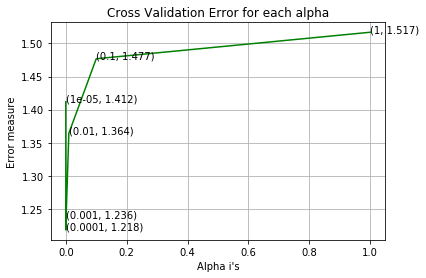

In [56]:
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty="l2", loss="log", random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    loss = log_loss(y_cv, predict_y, labels = clf.classes_, eps = 1e-15)
    cv_log_error_array.append(loss)
    print('For values of alpha = ', i, "The log loss is:", loss)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
    

In [57]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For value of best alpha = ', alpha[best_alpha])
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For value of best alpha =  0.0001
The train log loss is: 1.0610184060438492
The cross validation log loss is: 1.218195535030227
The test log loss is: 1.183000039655142


<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [58]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  241  genes in train dataset?
Ans
1. In test data 649 out of 665 : 97.59398496240601
2. In cross validation data 521 out of  532 : 97.93233082706767


### 3.2.2 Univariate Analysis on Variation Feature

<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [74]:
unique_variations = train_df['Variation'].value_counts()
print("Number of Unique Variations: ", unique_variations.shape[0])
print(unique_variations.head(10))

Number of Unique Variations:  1928
Truncating_Mutations    57
Deletion                48
Amplification           44
Fusions                 21
Overexpression           4
Q61R                     3
G12V                     3
Q61L                     2
G13V                     2
P130S                    2
Name: Variation, dtype: int64


There are 1928 different categories of variations in the train data, and they are distibuted as follows:

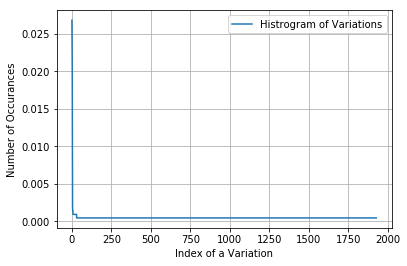

In [75]:
s = sum(unique_variations.values)
h = unique_variations.values/s
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

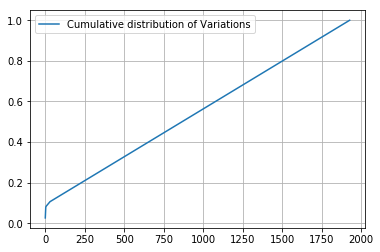

In [81]:
c = np.cumsum(h)
plt.plot(c, label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q9.</b> How to featurize this Variation feature ?</p>
<p style="font-size:16px;"><b>Ans:</b> There are two ways we can featurize this variable</p>
1. One Hot Encoding
2. Response Coding

In [84]:
# Response Coding
alpha = 1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))
print("Shape of variation feature", train_variation_feature_responseCoding.shape)

Shape of variation feature (2124, 9)


In [94]:
# One Hot Encoding
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])
print("The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

The shape of Variation feature: (2124, 1961)


<p style="font-size:18px;"> <b>Q10.</b> How good is this Variation feature  in predicting y_i?</p>

In [95]:
alpha = [10**i for i in range(-5, 1)]
# SGDClassifier

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7232425549697796
For values of alpha =  0.0001 The log loss is: 1.7083792149119983
For values of alpha =  0.001 The log loss is: 1.7144876052589602
For values of alpha =  0.01 The log loss is: 1.7220523674888
For values of alpha =  0.1 The log loss is: 1.726069769409722
For values of alpha =  1 The log loss is: 1.7278840514797016


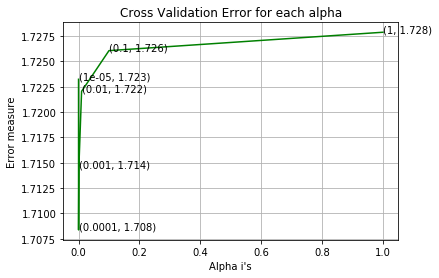

In [96]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [97]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For value of best alpha: ', alpha[best_alpha])
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For value of best alpha:  0.0001
The train log loss is: 0.7678854638472933
The cross validation log loss is: 1.7083792149119983
The test log loss is: 1.6840045057984612


<p style="font-size:18px;"> <b>Q11.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>

<p style="font-size:16px;"> <b>Ans.</b> Not sure! But lets be very sure using the below analysis. </p>

In [99]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 70 out of 665 : 10.526315789473683
2. In cross validation data 55 out of  532 : 10.338345864661653


### 3.2.3 Univariate Analysis on Text Feature

In [100]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
    return dictionary

In [101]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0], 9))
    for i in range(0, 9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log((dict_list[i].get(word, 0) + 10)/(total_dict.get(word, 0) + 90))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [106]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
train_text_features= text_vectorizer.get_feature_names()
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))
print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52076


In [107]:
# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
dict_list = []
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))
    
total_dict = extract_dictionary_paddle(train_df)

In [108]:
confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [109]:
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [110]:
# Converting each row such that they sum to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [111]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [112]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [113]:
print(Counter(sorted_text_occur))

Counter({3: 5072, 4: 3120, 6: 2676, 5: 2625, 8: 2353, 7: 1803, 9: 1664, 12: 1514, 10: 1496, 11: 1049, 14: 974, 16: 849, 18: 801, 15: 765, 13: 743, 17: 642, 24: 611, 20: 580, 19: 525, 21: 516, 22: 442, 30: 394, 25: 391, 27: 381, 28: 363, 23: 363, 26: 358, 32: 329, 41: 308, 36: 298, 51: 295, 29: 278, 33: 265, 35: 259, 34: 247, 31: 246, 42: 238, 38: 214, 48: 209, 40: 204, 37: 190, 43: 182, 44: 178, 39: 178, 45: 176, 54: 160, 52: 160, 46: 150, 60: 146, 49: 146, 55: 142, 50: 142, 47: 137, 58: 134, 56: 129, 53: 129, 59: 128, 72: 124, 57: 120, 67: 118, 65: 113, 64: 109, 78: 107, 61: 107, 62: 102, 74: 101, 86: 99, 84: 99, 63: 97, 66: 92, 70: 90, 71: 87, 68: 84, 73: 82, 69: 82, 81: 81, 76: 80, 75: 80, 80: 77, 85: 75, 87: 74, 77: 74, 96: 73, 92: 73, 102: 70, 98: 69, 82: 68, 105: 67, 89: 67, 79: 65, 99: 62, 93: 61, 97: 60, 91: 60, 90: 60, 83: 60, 114: 58, 112: 57, 88: 57, 100: 53, 115: 49, 109: 49, 94: 49, 129: 48, 113: 48, 110: 48, 108: 47, 107: 47, 104: 47, 120: 46, 103: 46, 127: 45, 126: 45, 1

For values of alpha =  1e-05 The log loss is: 1.4235393050810188
For values of alpha =  0.0001 The log loss is: 1.3876488178198574
For values of alpha =  0.001 The log loss is: 1.2776537344759262
For values of alpha =  0.01 The log loss is: 1.3601650907507192
For values of alpha =  0.1 The log loss is: 1.4906358556932593
For values of alpha =  1 The log loss is: 1.6800861681992088


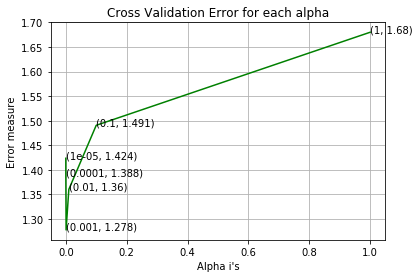

In [115]:
# Training a Logistic regression + Calibration model using text features
alpha = [10 ** x for x in range(-5, 1)]
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i, penalty = "l2", loss = "log", random_state = 42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [116]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For value of best alpha: ', alpha[best_alpha])
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For value of best alpha:  0.001
The train log loss is: 0.7751518242979456
The cross validation log loss is: 1.2776537344759262
The test log loss is: 1.1462720058429803


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

In [118]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.151 % of word of test data appeared in train data
97.397 % of word of Cross Validation appeared in train data


# 4. Machine Learning Models

In [119]:
def predict_plot_confusion_matrix(train_x, train_y, test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)
    
    print("Log loss: ", log_loss(test_y, sig_clf.predict_proba(test_x)))
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)
    
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [125]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)

    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i, v in enumerate(indices):
        if v < fea1_len:
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif v < (fea1_len + fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))
                
    print("Out of the top ",no_features," features ", word_present, "are present in query point")

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [126]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [127]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 54278)
(number of data points * number of features) in test data =  (665, 54278)
(number of data points * number of features) in cross validation data = (532, 54278)


In [128]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## 4.1. Base Line Model

### 4.1.1. Naive Bayes

#### 4.1.1.1. Hyper parameter tunning

In [132]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array = []
for i in alpha:
    print("For alpha: ", i)
    clf = MultinomialNB(alpha = i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))
    

For alpha:  1e-05
Log Loss : 1.3413590592088271
For alpha:  0.0001
Log Loss : 1.3322596010702374
For alpha:  0.001
Log Loss : 1.3391028833024028
For alpha:  0.01
Log Loss : 1.3276597958863328
For alpha:  0.1
Log Loss : 1.3246940983974202
For alpha:  1
Log Loss : 1.3630589394032058
For alpha:  10
Log Loss : 1.4502661867504993
For alpha:  100
Log Loss : 1.4157992251865998
For alpha:  1000
Log Loss : 1.3771415926179553


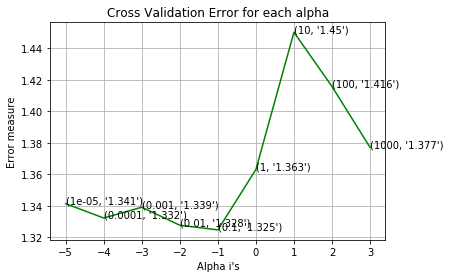

In [133]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [134]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.9164947204151916
For values of best alpha =  0.1 The cross validation log loss is: 1.3246940983974202
For values of best alpha =  0.1 The test log loss is: 1.2358992201407863


#### 4.1.1.2. Testing the model with best hyper paramters

Log Loss : 1.3246940983974202
Number of missclassified point : 0.43045112781954886
-------------------- Confusion matrix --------------------


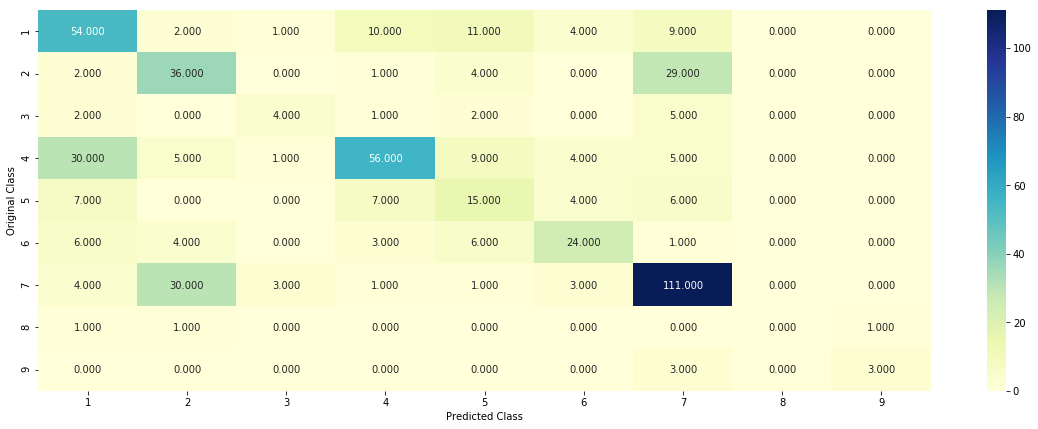

-------------------- Precision matrix (Columm Sum=1) --------------------


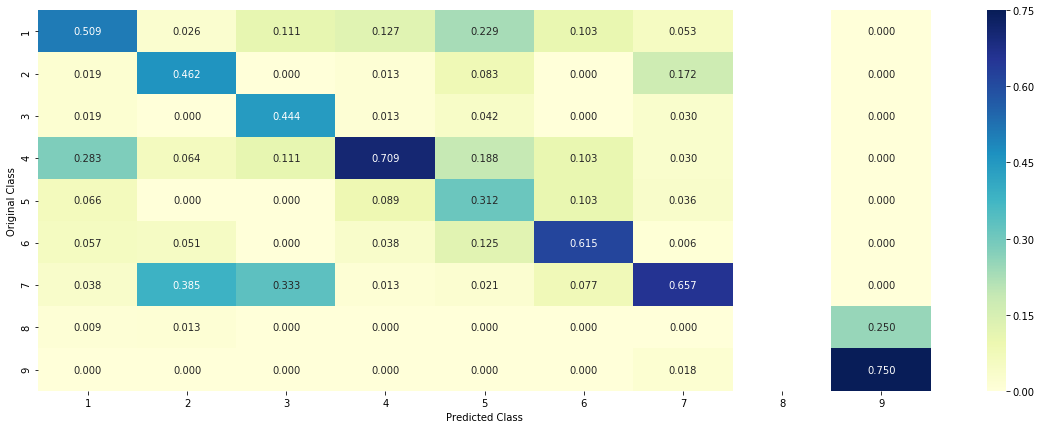

-------------------- Recall matrix (Row sum=1) --------------------


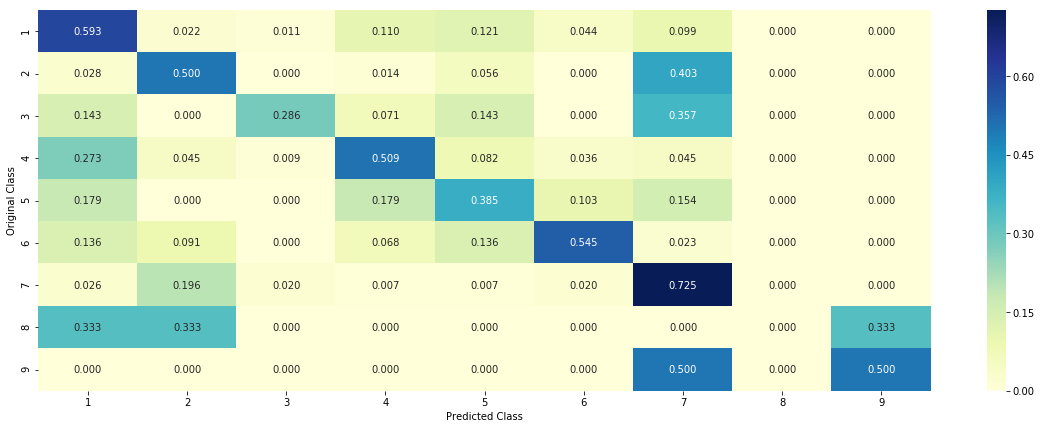

In [135]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

#### 4.1.1.3. Feature Importance, Correctly classified point

In [140]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.0848 0.0716 0.012  0.6382 0.0338 0.0327 0.1191 0.0043 0.0037]]
Actual Class : 4
--------------------------------------------------
9 Text feature [function] present in test data point [True]
14 Text feature [protein] present in test data point [True]
15 Text feature [activity] present in test data point [True]
17 Text feature [acid] present in test data point [True]
18 Text feature [experiments] present in test data point [True]
19 Text feature [proteins] present in test data point [True]
22 Text feature [amino] present in test data point [True]
24 Text feature [retained] present in test data point [True]
27 Text feature [results] present in test data point [True]
30 Text feature [ability] present in test data point [True]
34 Text feature [bind] present in test data point [True]
36 Text feature [determined] present in test data point [True]
38 Text feature [affect] present in test data point [True]
43 Text feature [transfection] pr

#### 4.1.1.4. Feature Importance, Incorrectly classified point

In [141]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.101  0.3654 0.0141 0.117  0.0398 0.0382 0.3152 0.005  0.0044]]
Actual Class : 7
--------------------------------------------------
16 Text feature [identified] present in test data point [True]
17 Text feature [including] present in test data point [True]
19 Text feature [sequencing] present in test data point [True]
26 Text feature [clinical] present in test data point [True]
27 Text feature [molecular] present in test data point [True]
29 Text feature [different] present in test data point [True]
30 Text feature [may] present in test data point [True]
31 Text feature [mutational] present in test data point [True]
32 Text feature [mutations] present in test data point [True]
33 Text feature [well] present in test data point [True]
34 Text feature [another] present in test data point [True]
35 Text feature [case] present in test data point [True]
36 Text feature [small] present in test data point [True]
37 Text feature [using] pres

## 4.2. Logistic Regression

### 4.2.1. With Class Balancing

#### 4.2.1.1. Hyper Parameter Tuning

In [150]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("For alpha: ", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))

For alpha:  1e-06
Log Loss : 1.4282701431271836
For alpha:  1e-05
Log Loss : 1.4160192805291776
For alpha:  0.0001
Log Loss : 1.2964405224528845
For alpha:  0.001
Log Loss : 1.123261294433114
For alpha:  0.01
Log Loss : 1.2421314768000329
For alpha:  0.1
Log Loss : 1.5404985145197103
For alpha:  1
Log Loss : 1.7399214349335836
For alpha:  10
Log Loss : 1.772200491791445
For alpha:  100
Log Loss : 1.7759008569942445


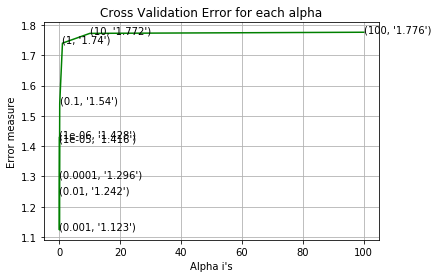

In [151]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [152]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha: ', alpha[best_alpha])
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print("The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha:  0.001
The train log loss is: 0.6426172525886328
The cross validation log loss is: 1.123261294433114
The test log loss is: 1.0403652457711396


#### 4.2.1.2. Testing the model with best hyper parameter

Log loss:  1.123261294433114
Number of mis-classified points : 0.35714285714285715
-------------------- Confusion matrix --------------------


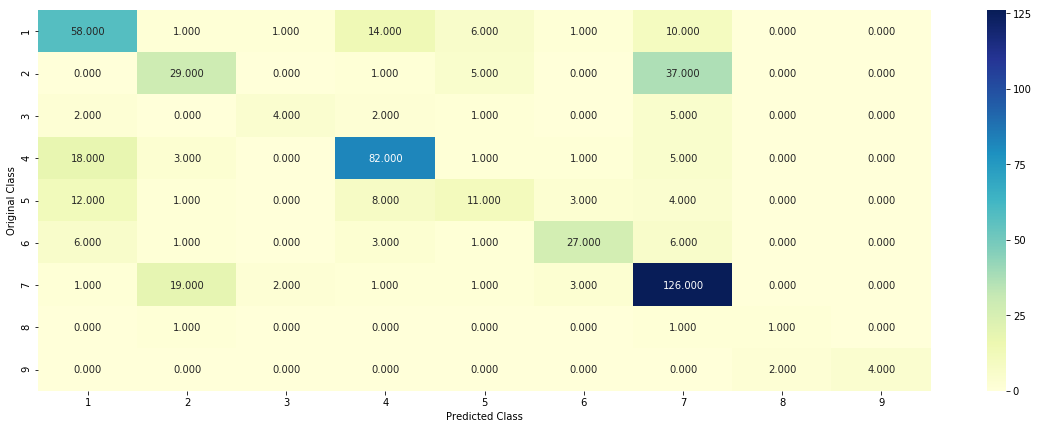

-------------------- Precision matrix (Columm Sum=1) --------------------


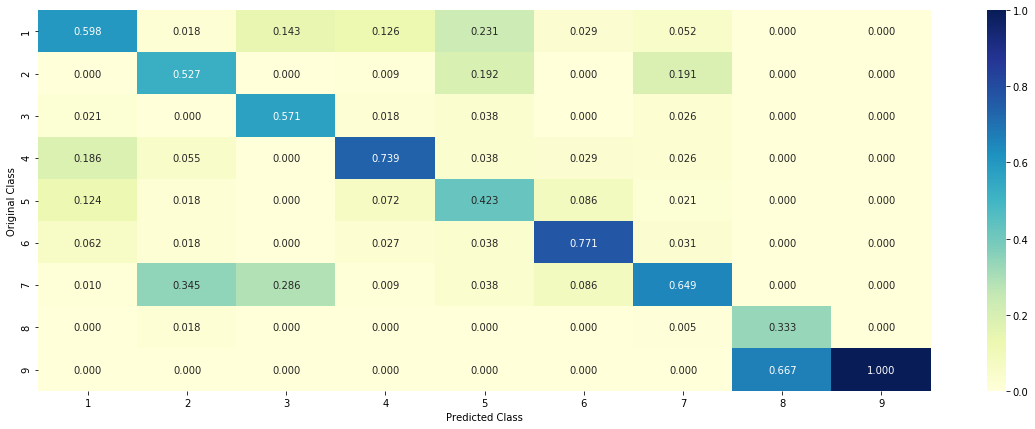

-------------------- Recall matrix (Row sum=1) --------------------


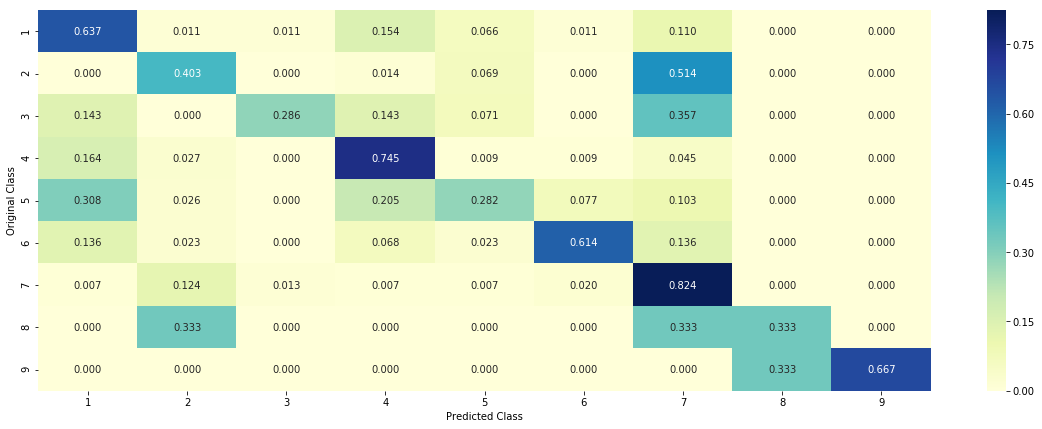

In [154]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4.2.1.3. Feature Importance

##### 4.2.1.3.1. Correctly Classified point

In [155]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0419 0.336  0.0149 0.0448 0.0366 0.0277 0.4846 0.0069 0.0065]]
Actual Class : 7
--------------------------------------------------
37 Text feature [constitutive] present in test data point [True]
76 Text feature [tyr204] present in test data point [True]
141 Text feature [thr202] present in test data point [True]
159 Text feature [cdnas] present in test data point [True]
160 Text feature [transformed] present in test data point [True]
164 Text feature [technology] present in test data point [True]
208 Text feature [expressing] present in test data point [True]
218 Text feature [ligand] present in test data point [True]
221 Text feature [doses] present in test data point [True]
274 Text feature [receptor] present in test data point [True]
282 Text feature [concentrations] present in test data point [True]
374 Text feature [inhibitor] present in test data point [True]
396 Text feature [inhibited] present in test data point [True]
418

##### 4.2.1.3.2. Incorrectly Classified point

In [162]:
test_point_index = 5
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0436 0.0697 0.0148 0.0961 0.0338 0.0232 0.7079 0.0057 0.0053]]
Actual Class : 4
--------------------------------------------------
17 Text feature [3t3] present in test data point [True]
19 Text feature [seaplaque] present in test data point [True]
26 Text feature [transforming] present in test data point [True]
37 Text feature [constitutive] present in test data point [True]
81 Text feature [receptors] present in test data point [True]
151 Text feature [nude] present in test data point [True]
158 Text feature [phosphotyrosine] present in test data point [True]
159 Text feature [cdnas] present in test data point [True]
160 Text feature [transformed] present in test data point [True]
162 Text feature [activated] present in test data point [True]
201 Text feature [enhance] present in test data point [True]
208 Text feature [expressing] present in test data point [True]
218 Text feature [ligand] present in test data point [True]
226 T

### 4.2.2 Without Class Balancing

#### 4.2.2.1. Hyper Parameter Tuning

In [163]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.395136520939653
for alpha = 1e-05
Log Loss : 1.3854482874552316
for alpha = 0.0001
Log Loss : 1.3301881402001798
for alpha = 0.001
Log Loss : 1.1885532992516545
for alpha = 0.01
Log Loss : 1.272625438040719
for alpha = 0.1
Log Loss : 1.4063439434160285
for alpha = 1
Log Loss : 1.6278140470601137


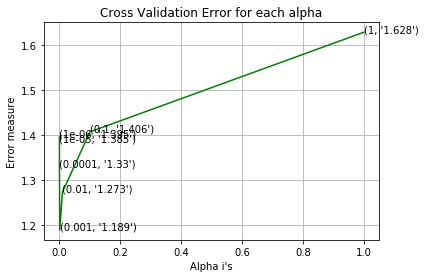

In [164]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [165]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.6389122131175811
For values of best alpha =  0.001 The cross validation log loss is: 1.1885532992516545
For values of best alpha =  0.001 The test log loss is: 1.0709236916188078


#### 4.2.2.2. Testing model with best hyper parameters

Log loss:  1.1885532992516545
Number of mis-classified points : 0.37030075187969924
-------------------- Confusion matrix --------------------


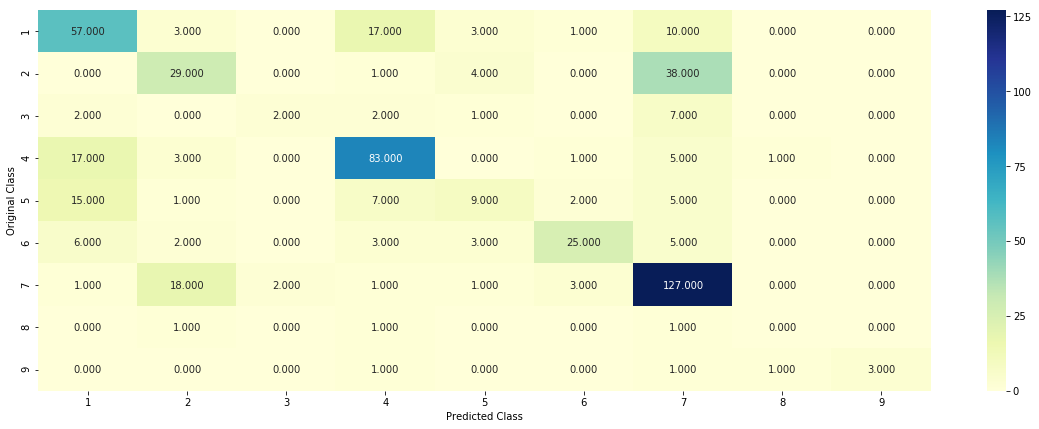

-------------------- Precision matrix (Columm Sum=1) --------------------


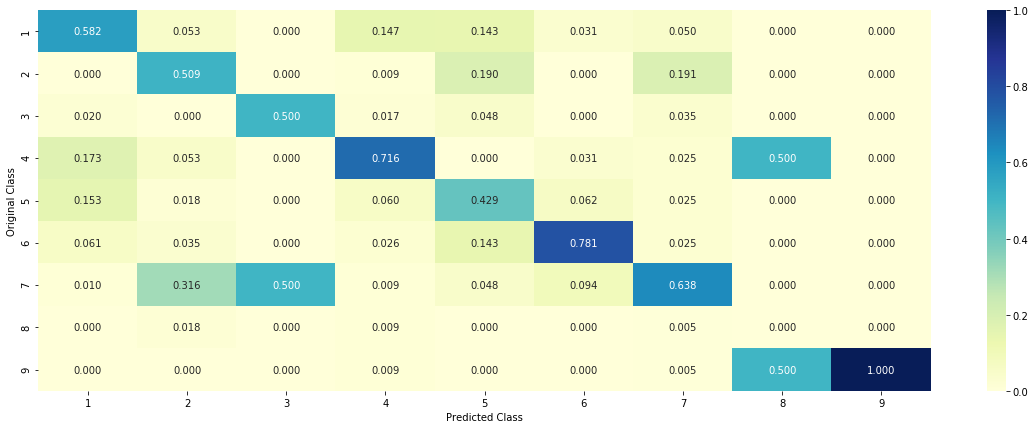

-------------------- Recall matrix (Row sum=1) --------------------


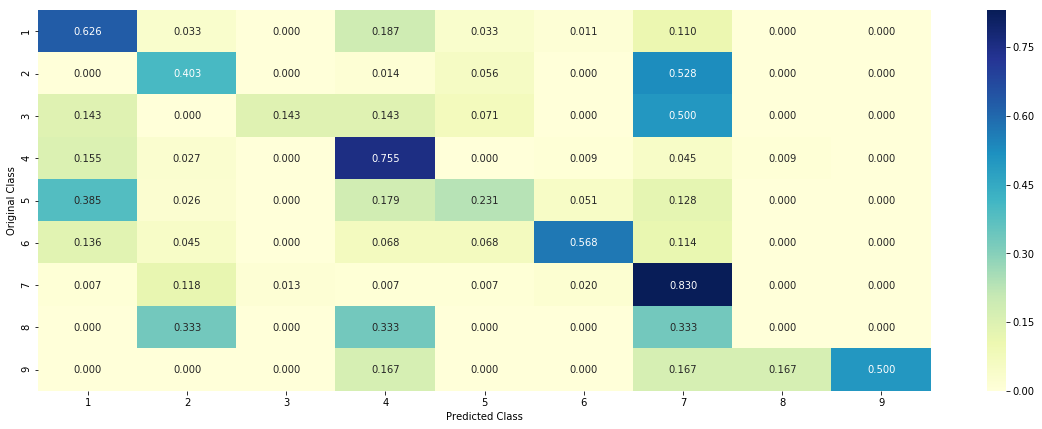

In [167]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

#### 4.2.2.3. Feature Importance, Correctly Classified point

In [168]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0443 0.319  0.0079 0.0457 0.0318 0.0252 0.517  0.0067 0.0023]]
Actual Class : 7
--------------------------------------------------
151 Text feature [constitutive] present in test data point [True]
203 Text feature [tyr204] present in test data point [True]
213 Text feature [technology] present in test data point [True]
231 Text feature [transformed] present in test data point [True]
276 Text feature [thr202] present in test data point [True]
293 Text feature [cdnas] present in test data point [True]
317 Text feature [expressing] present in test data point [True]
340 Text feature [activating] present in test data point [True]
341 Text feature [doses] present in test data point [True]
391 Text feature [concentrations] present in test data point [True]
421 Text feature [receptor] present in test data point [True]
449 Text feature [extracellular] present in test data point [True]
461 Text feature [inhibitor] present in test data point 

#### 4.2.2.4. Feature Importance, Inorrectly Classified point

In [169]:
test_point_index = 5
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0439 0.0687 0.0077 0.0947 0.0314 0.022  0.7238 0.0059 0.002 ]]
Actual Class : 4
--------------------------------------------------
55 Text feature [3t3] present in test data point [True]
77 Text feature [seaplaque] present in test data point [True]
105 Text feature [transforming] present in test data point [True]
151 Text feature [constitutive] present in test data point [True]
231 Text feature [transformed] present in test data point [True]
246 Text feature [receptors] present in test data point [True]
255 Text feature [transform] present in test data point [True]
261 Text feature [oncogene] present in test data point [True]
288 Text feature [enhance] present in test data point [True]
293 Text feature [cdnas] present in test data point [True]
297 Text feature [autophosphorylation] present in test data point [True]
317 Text feature [expressing] present in test data point [True]
319 Text feature [grew] present in test data point [Tr